<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/Assignment0_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.0 MB/s eta 0:00:00


In [4]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

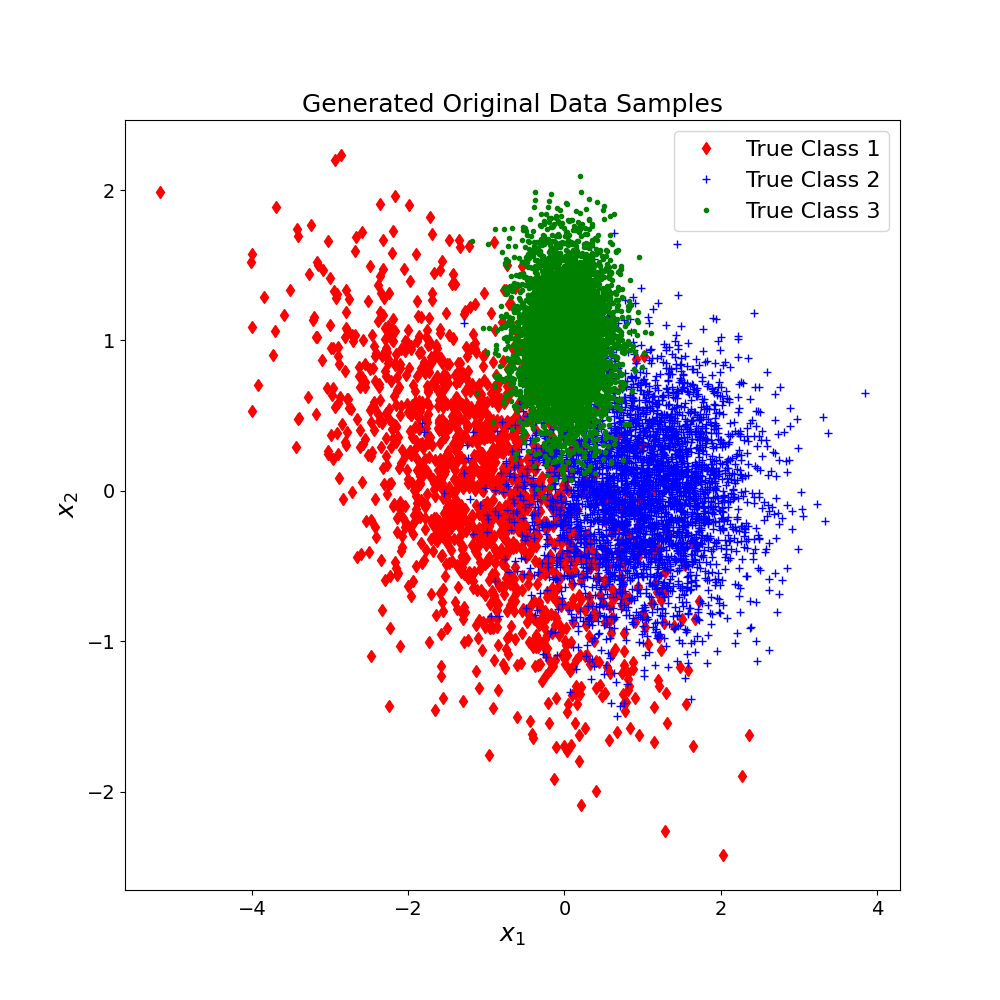

In [10]:
N = 10000

# Mean and covariance of data PDFs conditioned on labels
mu = np.array([[-1, 0],
               [1, 0],
               [0, 1]])  # Gaussian distributions means
Sigma = np.array([[[1, -0.4],
                   [-0.4, 0.5]],
                  [[0.5, 0],
                   [0, 0.2]],
                  [[0.1, 0],
                   [0, 0.1]]])  # Gaussian distributions covariance matrices
# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.15, 0.35, 0.5])
C = len(priors)
# Decide randomly which samples will come from each component
u = np.random.rand(N)
thresholds = np.cumsum(priors)
thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

# Output samples and labels
X = np.zeros([N, n])
labels = np.zeros(N) # KEEP TRACK OF THIS

# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = 'd+.'
marker_colors = 'rbg'

L = np.array(range(1, C+1))
for l in L:
    # Get randomly sampled indices for this component
    indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
    # No. of samples in this component
    Nl = len(indices)
    labels[indices] = l * np.ones(Nl)
    X[indices, :] =  multivariate_normal.rvs(mu[l-1], Sigma[l-1], Nl)
    plt.plot(X[labels==l, 0], X[labels==l, 1], marker_shapes[l-1] + marker_colors[l-1], label="True Class {}".format(l))


# Plot the original data and their true labels
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Generated Original Data Samples")
#plt.tight_layout()
plt.show()

## Actual number of samples that were generated from each class;

In [11]:
Nl = np.array([sum(labels == l) for l in L])
print("Number of samples from Class 1: {:d}, Class 2: {:d}, Class 3: {:d}".format(Nl[0], Nl[1], Nl[2]))

Number of samples from Class 1: 1505, Class 2: 3509, Class 3: 4986


In [13]:
# Min prob. of error classifier
# Conditional likelihoods of each x given each class, shape (C, N)
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[c], Sigma[c]) for c in range(C)])
# Take diag so we have (C, C) shape of priors with prior prob along diagonal
class_priors = np.diag(priors)
# class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
# with each class as a row and N columns for samples, e.g. row 1: [p(L=1)p(x_1|L=1), ..., p(L=1)p(x_N|L=1)]
class_posteriors = class_priors.dot(class_cond_likelihoods)

# MAP rule, take largest class posterior per example as your decisions matrix (N, 1)
# Careful of indexing! Added np.ones(N) just for difference in starting from 0 in Python and labels={1,2,3}
decisions = np.argmax(class_posteriors, axis=0) + np.ones(N)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
# NOTE ORDER OF DECISIONS AND LABELS
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)
correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

# Alternatively work out probability error based on incorrect decisions per class
# perror_per_class = np.array(((conf_mat[1,0]+conf_mat[2,0])/Nl[0], (conf_mat[0,1]+conf_mat[2,1])/Nl[1], (conf_mat[0,2]+conf_mat[1,2])/Nl[2]))
# prob_error = perror_per_class.dot(Nl.T / N)

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[1214  162   19]
 [ 201 3118  109]
 [  90  229 4858]]
Total Mumber of Misclassified Samples: 810
Empirically Estimated Probability of Error: 0.0810


Text(0.5, 0, 'True Labels')

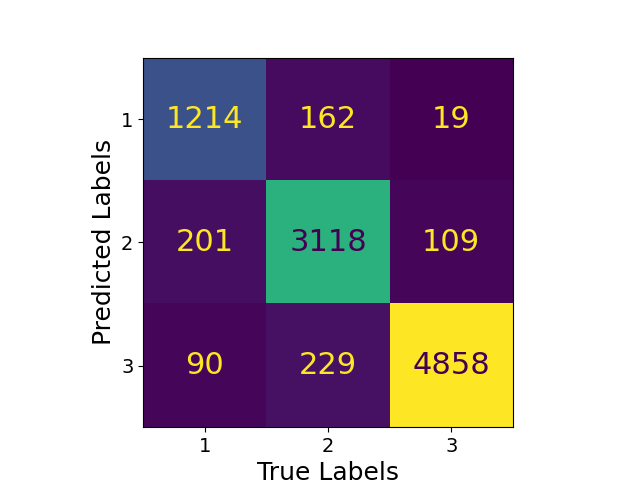

In [14]:
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, display_labels=['1', '2', '3'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

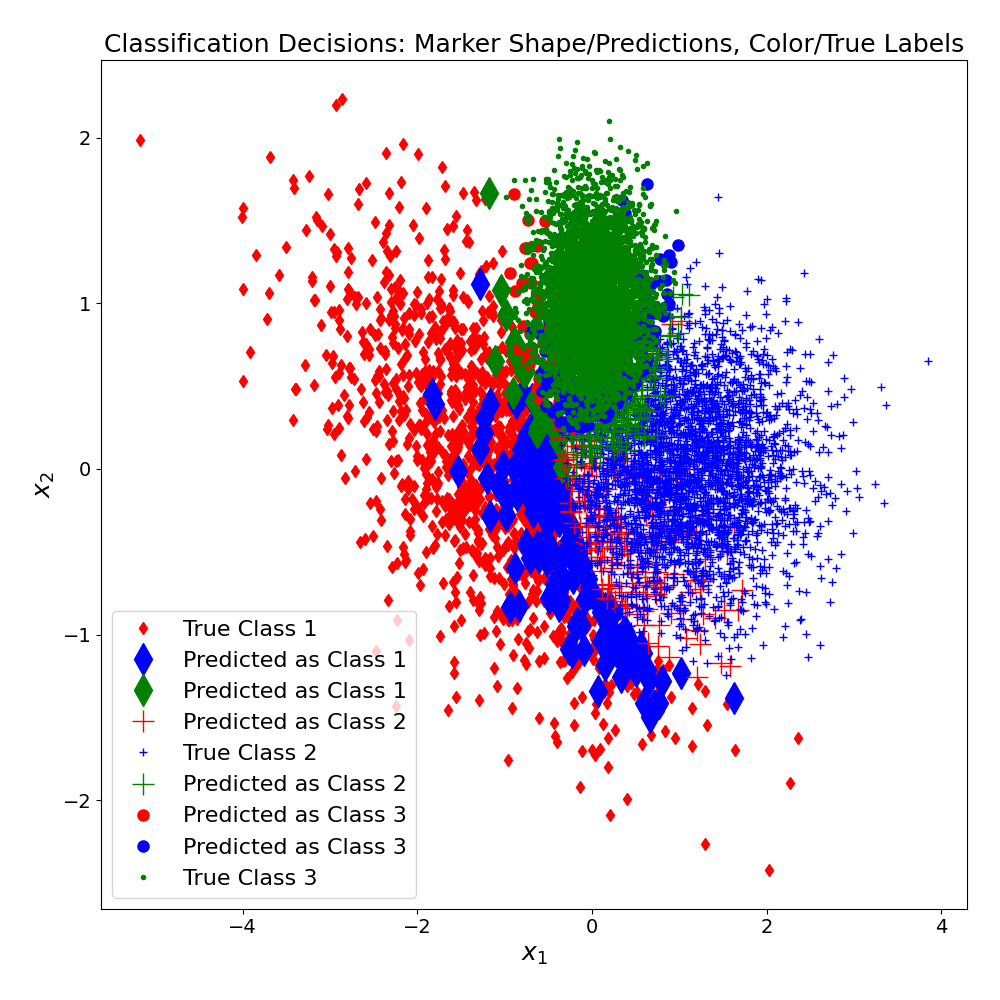

In [17]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))

for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        marker = marker_shapes[r-1] + marker_colors[c-1]
        if r == c:
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker, label="True Class {}".format(c))
        else:
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker, markersize=16, label="Predicted as Class {}".format(r))

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

#A clear but brief description of the results presented as described above;

The confusion matrix and minimum probability of error estimate demonstrate high classification performance, with a low misclassification rate. The graph further validates this claim and as one would expect, shows that classification performance is mostly hampered where the Gaussian class-conditional PDFs overlap.

# Question 2

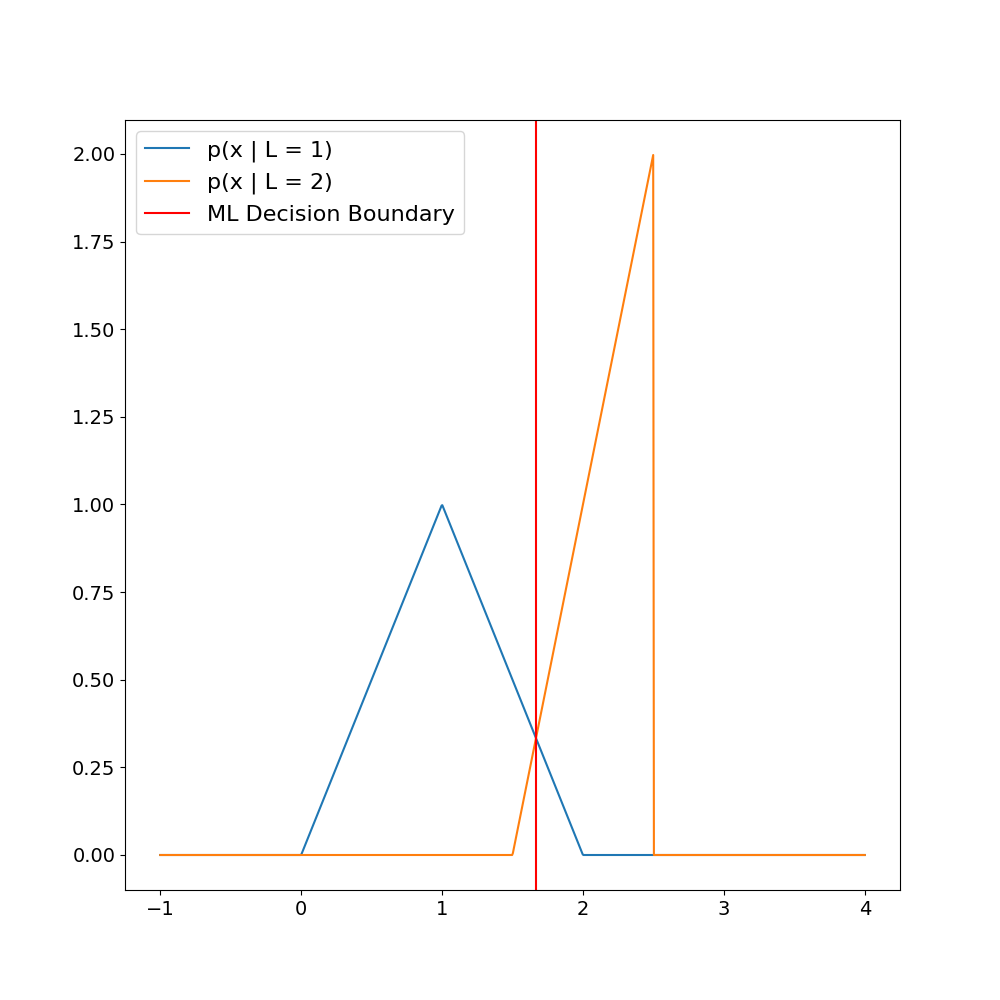

In [19]:
fig = plt.figure(figsize=(10, 10))

x = np.linspace(-1, 4, 1000)
px_l1 = np.zeros(len(x))
px_l1[(0 <= x) & (x < 1)] = x[(0 <= x) & (x < 1)]
px_l1[(1 <= x) & (x <= 2)] = 2 - x[(1 <= x) & (x <= 2)]
plt.plot(x, px_l1, label="p(x | L = 1)")

px_l2 = np.zeros(len(x))
px_l2[(1.5 <= x) & (x <= 2.5)] = 2*x[(1.5 <= x) & (x <= 2.5)] - 3
plt.plot(x, px_l2, label="p(x | L = 2)")

# For ML case where priors equal...
plt.axvline(x=5/3, color='r', label="ML Decision Boundary")

plt.legend()
plt.show()

# Question 3

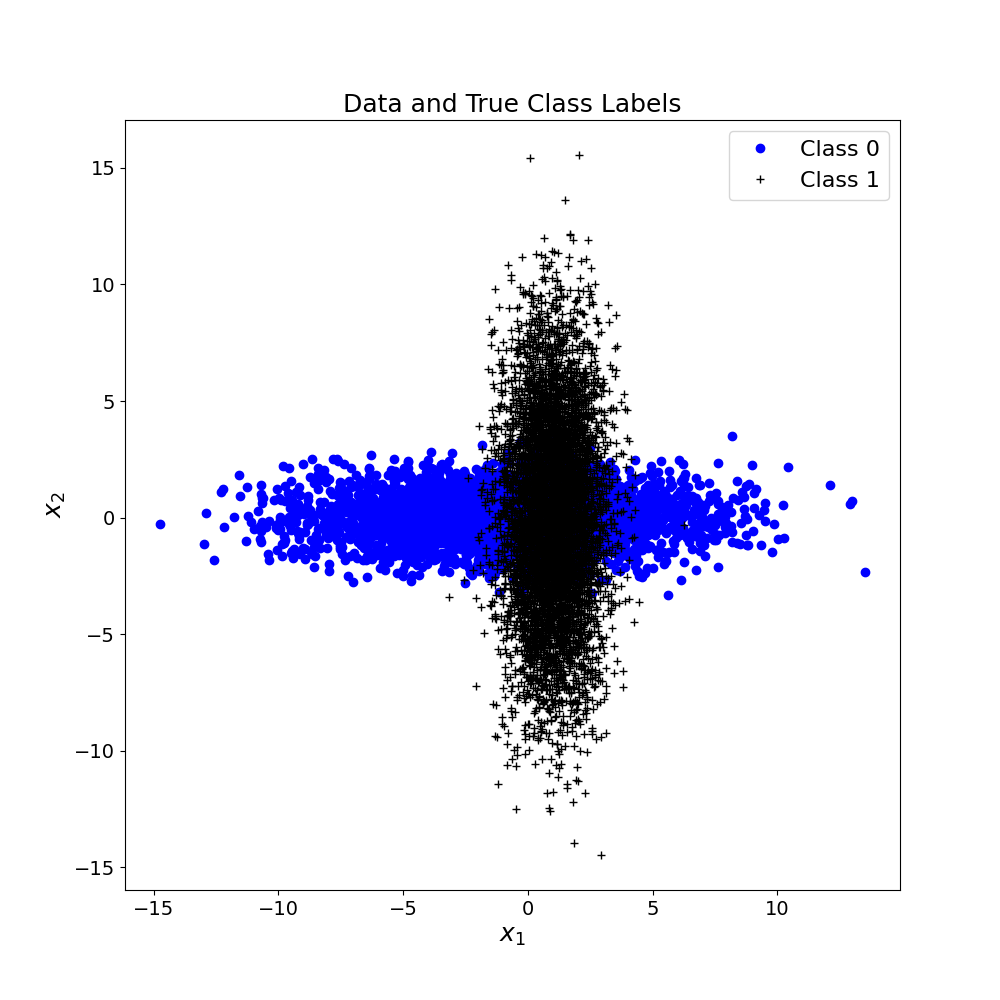

In [21]:
# Mean and covariance of data PDFs conditioned on labels
mu = np.array([[-1, 0],
               [1, 0]])  # Gaussian distributions means
Sigma = np.array([[[16, 0],
                   [0, 1]],
                  [[1, 0],
                   [0, 16]]])  # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.35, 0.65])
C = len(priors)
# Decide randomly which samples will come from each component (taking class 1 from uniform [0,1] sampled values above 0.35)
labels = np.random.rand(N) >= priors[0]
L = np.array(range(C))
Nl = np.array([sum(labels == l) for l in L])

# Draw samples from each class PDF
X = np.zeros((N, n))
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1])


# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'bo', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'k+', label="Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Class Labels")
#plt.tight_layout()
plt.show()

Make the
 threshold take many values along the positive real axis, and for each threshold value, classify every sample. Empirically estimate the true-positive and false-positive probabilities (by counting samples that fall into each category), and then plot the true-positive versus false-positive performance at each threshold using an ROC curve. Sweep the positive real axis by sampling densely to see the true-positive vs false-positive curves for the classifier in detail. Hint: sweep through the sorted values for every possible classification split, as determined by the difference in class-conditional log-likelihoods per sample.

##  Minimum Expected Loss Classifier

In [24]:
# MAP classifier (is a special case of ERM corresponding to 0-1 loss)
# 0-1 loss values yield MAP decision rule
Lambda = np.ones((C, C)) - np.identity(C)
print(Lambda)

[[0. 1.]
 [1. 0.]]


In [25]:
# Expected Risk Minimization Classifier (using true model parameters)
# In practice the parameters would be estimated from training samples
# Using log-likelihood-ratio as the discriminant score for ERM
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L])
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Gamma threshold for MAP decision rule (remove Lambdas and you obtain same gamma on priors only; 0-1 loss simplification)
gamma_map = (Lambda[1,0] - Lambda[0,0]) / (Lambda[0,1] - Lambda[1,1]) * priors[0] / priors[1]
# Same as:
# gamma_map = priors[0]/priors[1]
print(gamma_map)

0.5384615384615384


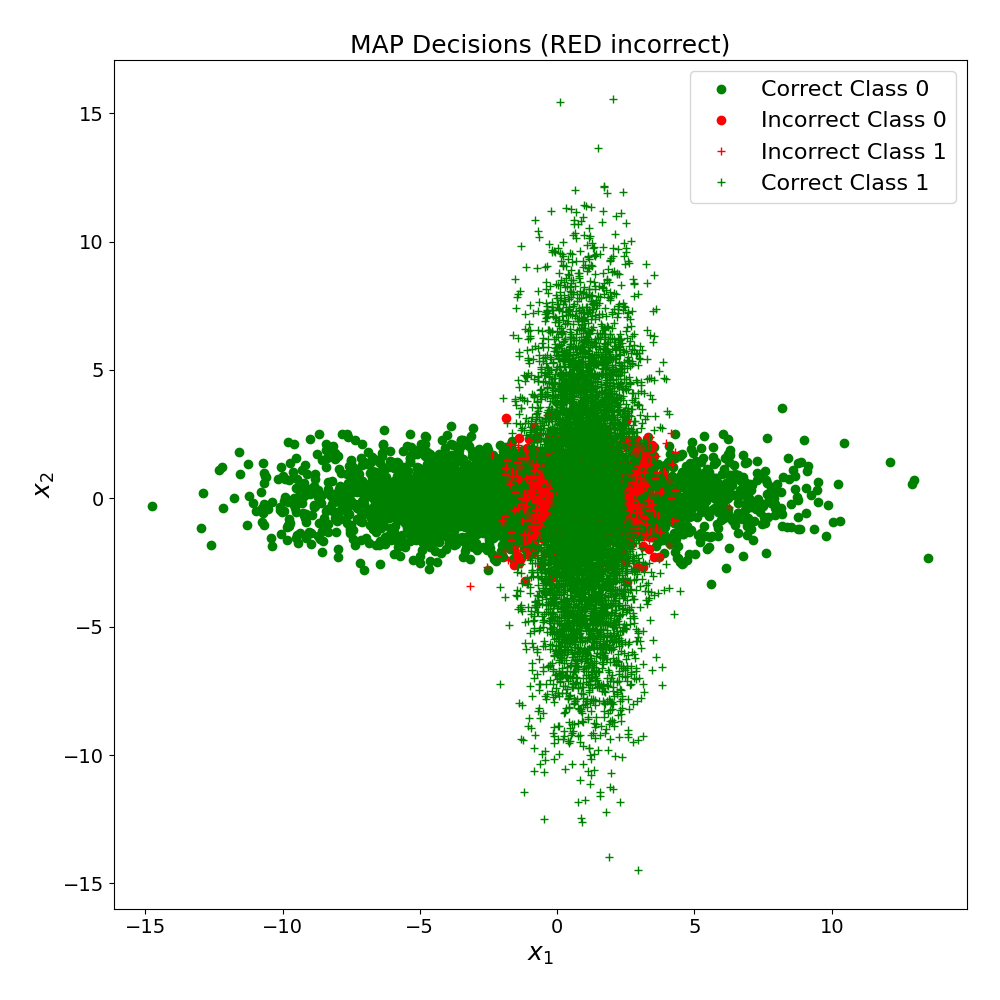

In [26]:
decisions_map = discriminant_score_erm >= np.log(gamma_map)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Probability of error for MAP classifier
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)

# Display MAP decisions
fig = plt.figure(figsize=(10, 10))

# class 0 circle, class 1 +, correct green, incorrect red
plt.plot(X[ind_00_map, 0], X[ind_00_map, 1], 'og', label="Correct Class 0")
plt.plot(X[ind_10_map, 0], X[ind_10_map, 1], 'or', label="Incorrect Class 0")
plt.plot(X[ind_01_map, 0], X[ind_01_map, 1], '+r', label="Incorrect Class 1")
plt.plot(X[ind_11_map, 0], X[ind_11_map, 1], '+g', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MAP Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

### Let's define an ROC curve-generating function:

In [27]:
from sys import float_info # Threshold smallest positive floating value

# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]

    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]

    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    return roc, gammas

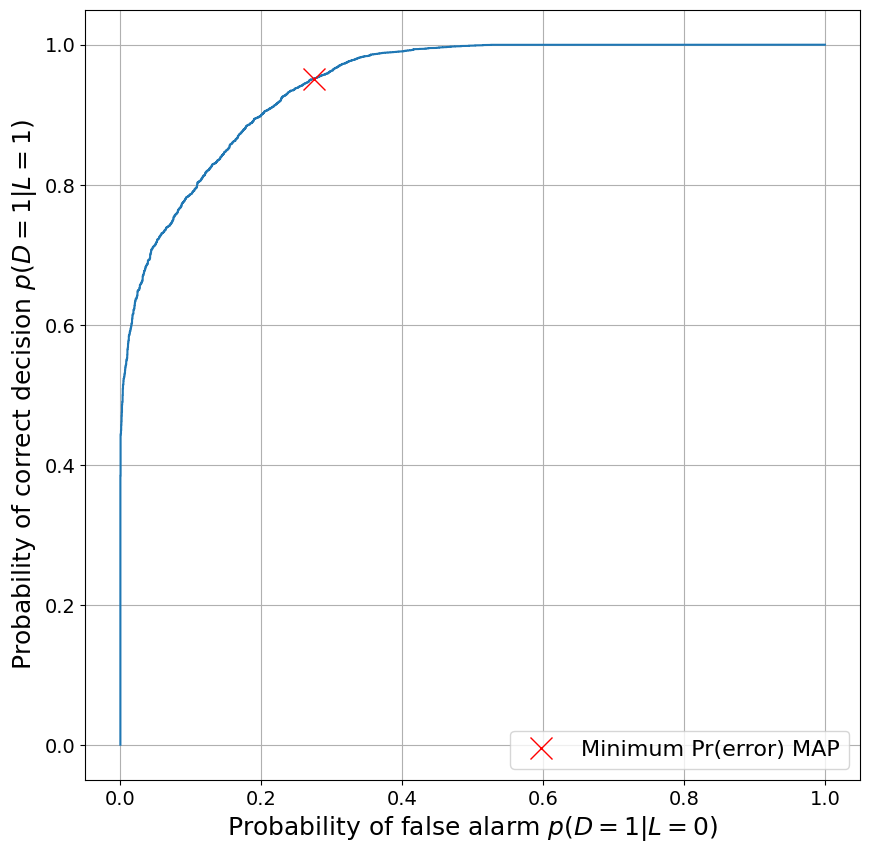

In [28]:
# Construct the ROC for ERM by changing log(gamma)
roc_erm, _ = estimate_roc(discriminant_score_erm, labels)
roc_map = np.array((p_10_map, p_11_map))

plt.ioff() # These are Jupyter only lines to avoid showing the figure when I don't want
fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
plt.ion() # Re-activate "interactive" mode

ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Minimum Pr(error) MAP", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $p(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $p(D=1|L=1)$")
plt.grid(True)
display(fig_roc) # Display as .png

fig_roc;

## Fisher's Linear Discriminant Analysis (LDA)

In [29]:
def perform_lda(X, mu, Sigma, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance parameters would be estimated from training samples.

    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """

    mu = np.array([mu[i].reshape(-1, 1) for i in range(C)])
    cov = np.array([Sigma[i].T for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z

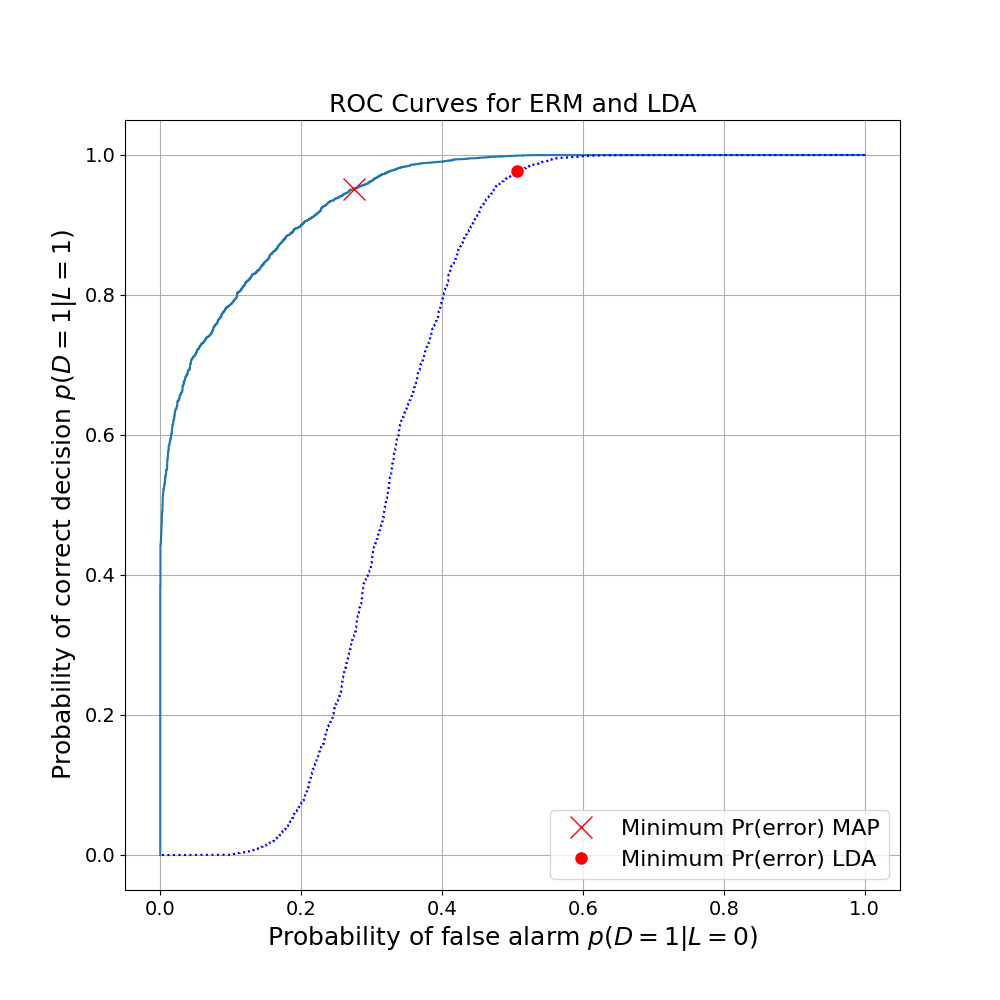

In [30]:
# Fisher LDA Classifer (using true model parameters)
_, discriminant_score_lda = perform_lda(X, mu, Sigma)

# Estimate the ROC curve for this LDA classifier
roc_lda, gamma_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda[0,:], 1 - roc_lda[1,:])).T.dot(Nl.T / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda[0], roc_lda[1], 'b:')
ax_roc.plot(roc_lda[0, min_ind], roc_lda[1, min_ind], 'r.', label="Minimum Pr(error) LDA", markersize=16)
ax_roc.set_title("ROC Curves for ERM and LDA")
ax_roc.legend()

plt.show()
fig_roc;

### Comment on the minimum probability of error estimates obtained for each classifier:

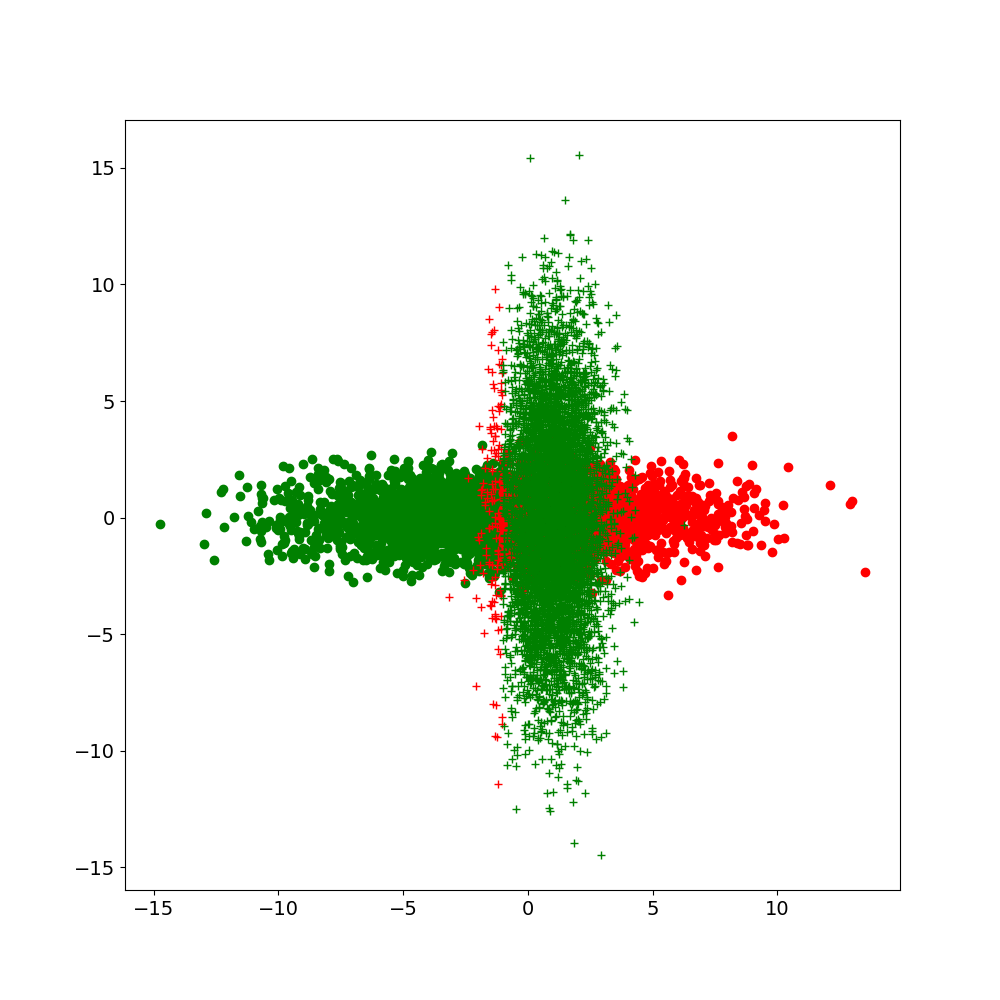

In [31]:
# Use min-error threshold
decisions_lda = discriminant_score_lda >= gamma_lda[min_ind]

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_lda = np.argwhere((decisions_lda==0) & (labels==0))
p_00_lda = len(ind_00_lda) / Nl[0]
# False Positive Probability
ind_10_lda = np.argwhere((decisions_lda==1) & (labels==0))
p_10_lda = len(ind_10_lda) / Nl[0]
# False Negative Probability
ind_01_lda = np.argwhere((decisions_lda==0) & (labels==1))
p_01_lda = len(ind_01_lda) / Nl[1]
# True Positive Probability
ind_11_lda = np.argwhere((decisions_lda==1) & (labels==1))
p_11_lda = len(ind_11_lda) / Nl[1]

# Display LDA decisions
fig = plt.figure(figsize=(10, 10));

# class 0 circle, class 1 +, correct green, incorrect red
plt.plot(X[ind_00_lda, 0], X[ind_00_lda, 1], 'og', label="Correct Class 0");
plt.plot(X[ind_10_lda, 0], X[ind_10_lda, 1], 'or', label="Incorrect Class 0");
plt.plot(X[ind_01_lda, 0], X[ind_01_lda, 1], '+r', label="Incorrect Class 1");
plt.plot(X[ind_11_lda, 0], X[ind_11_lda, 1], '+g', label="Correct Class 1");
plt.show()

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("LDA Decisions (RED incorrect)")
plt.tight_layout()

In [32]:
print("Smallest Pr(error) for ERM = {}".format(prob_error_erm))
print("Smallest Pr(error) for LDA = {}".format(min_prob_error_lda))

Smallest Pr(error) for ERM = 0.12780000000000002
Smallest Pr(error) for LDA = 0.1921


* Since the MAP classifier is designed to minimize probability error (when implemented with true class conditional likelihoods and class priors), we expected its error rate to be lower than that of all other classifiers, including Fisher's LDA. The numerical experiment is consistent with this theoretical result.

* We also note that since the dataset is random, occasionally (less frequently for larger ) the empirical probability of error estimate for Fisher's LDA may by chance be lower than that of the MAP classifier. This would occur due to random variations in probability of error estimates resulting from using sampled data.

* Observe that in this example problem, the ROC curve of Fisher's LDA classifier is nonconcave, clearly indicating a model mismatch -- the linear boundary is inappropriate for this case where a quadratic boundary is needed.